In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pickle
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
% matplotlib inline

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
#load pickles
model = pickle.load(open('random_forest_p', 'rb'))
ar_param = pickle.load(open('ar_parameters_p', 'rb'))

In [4]:
def get_clean_data(df_original):
    weekday_dict = {
        0:'Wd', 1:'Wd', 2:'Wd', 3:'Wd', 4:'Wd', 5:'F', 6:'F' 
    }
    
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df.replace({'weekday':weekday_dict}, inplace=True)
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'summer', 'winter')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','time', 'hour', 'minute', 'value']]
    clean_df = clean_df[~clean_df.index.duplicated()]
    clean_df['hour'] = np.where(clean_df['hour'].isin(np.arange(9,23)), 'Peak', 'off_peak')
    #clean_df['value'] = np.log1p(clean_df['value'])
    clean_df_freq = clean_df.asfreq('H')
    
    return clean_df_freq

### Import data from 2017

In [5]:
raw_band_price = pd.read_csv('2017_data/export_PrecioBandaDeRegulaciónSecundaria_2017-02-13_21-01.csv',
                             encoding='latin1', delimiter=';')
band_price = get_clean_data(raw_band_price)
band_price = band_price.rename(columns={'value':'band'})

In [6]:
raw_spot_price = pd.read_csv('2017_data/export_PrecioMercadoSPOTDiarioEspaña_2017-02-13_20-59.csv',
                             encoding='latin1', delimiter=';')
spot_price = get_clean_data(raw_spot_price)
spot_price = spot_price.rename(columns={'value':'spot'})

In [7]:
raw_demand = pd.read_csv('2017_data/export_DemandaProgramada_2017-02-13_20-58.csv',
                         encoding='latin1', delimiter=';')
demand = get_clean_data(raw_demand)
demand = demand.rename(columns={'value':'demand'})

In [8]:
spot_band_demand = band_price.merge(spot_price[['spot']], how='left', left_index=True, right_index=True)
spot_band_demand = spot_band_demand.merge(demand[['demand']], how='left', left_index=True, right_index=True)

In [9]:
spot_band_demand = spot_band_demand[['hour', 'weekday', 'season', 'spot','demand', 'band']]

In [10]:
for feature in ['hour', 'weekday', 'season']:
    spot_band_demand[pd.get_dummies(spot_band_demand[feature], drop_first=True).columns.tolist()] = pd.get_dummies(spot_band_demand[feature], drop_first=True)

In [11]:
for feature in ['demand', 'spot']:
    spot_band_demand[feature + '-1'] = spot_band_demand[feature].shift(periods=+1)
    spot_band_demand[feature + '-24'] = spot_band_demand[feature].shift(periods=+24)
spot_band_demand['band-24'] = spot_band_demand['band'].shift(periods=24)
spot_band_demand.dropna(subset=['demand-1', 'spot-1', 'demand-24', 'spot-24', 'band-24'], inplace=True)

In [12]:
spot_band_demand['winter'] =1

### Check predictions for 2017

In [13]:
X = spot_band_demand[['spot','demand', 'off_peak', 'Wd', 
                     'winter', 'demand-1', 'demand-24', 
                     'spot-1', 'spot-24', 'band-24']].values
Y = spot_band_demand['band'].values

In [14]:
y_pred = model.predict(X)

In [15]:
print('MAE: %.4f, MSE: %.4f' %(mean_absolute_error(Y, y_pred), mean_squared_error(Y, y_pred)))

MAE: 6.0118, MSE: 71.8618


In [16]:
residuals = pd.DataFrame(data=y_pred, index=spot_band_demand.index, columns=['y_pred'])

In [17]:
residuals['y_true'] = Y

In [18]:
residuals['error'] = residuals['y_true'] - residuals['y_pred']

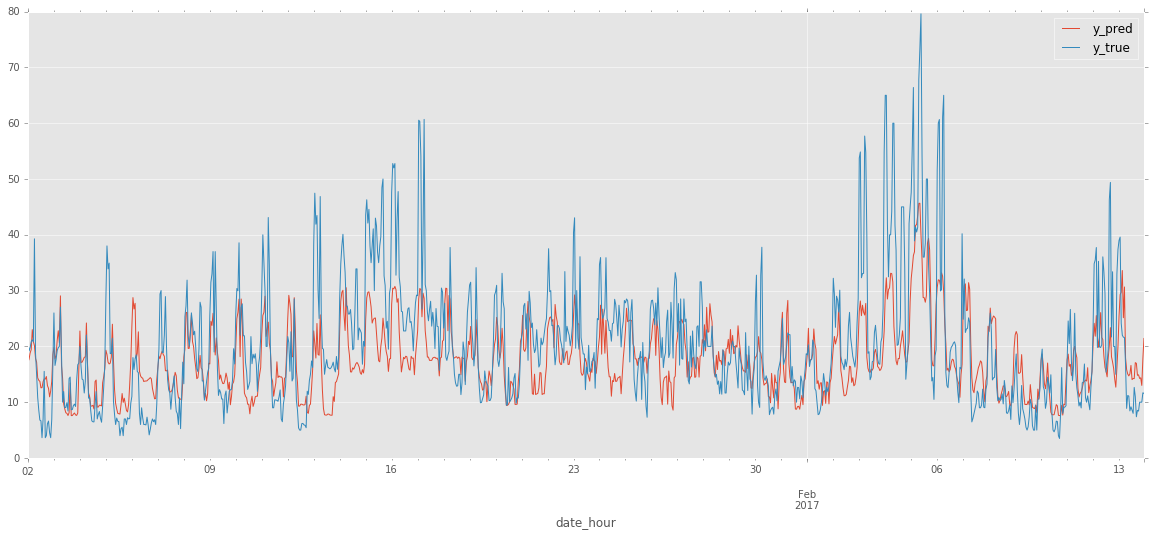

In [60]:
residuals[['y_pred', 'y_true']].plot(figsize=(20,8));

### Adding AR(3) effect
$$S_{t} = f(x)e^{X_{t}} \\$$
$$X_{t} = \alpha _{1}X_{t-1} + \alpha _{2}X_{t-2} + \alpha _{3}X_{t-3} +\epsilon _{t} \\$$

$$S_{t} = f(x)e^{(\alpha _{1}X_{t-1} + \alpha _{2}X_{t-2} + \alpha _{3}X_{t-3} +\epsilon _{t})}$$

##### One example without white noise

In [20]:
f_x = model.predict(X)

In [21]:
f_x.shape

(1032,)

In [22]:
residual = (np.log1p(Y) - np.log1p(f_x))

In [32]:
def compute_ar(arparams, x):
    result = np.dot(arparams, x[::-1])
    return result

In [33]:
res_ts =  np.zeros((len(residual)-3))

In [35]:
for t in range(0, len(residual)-3):
    res_ts[t] = compute_ar(ar_param, residual[t:t+3])

In [55]:
rf_ar_df = pd.DataFrame(data=f_x[3:]*np.exp(res_ts), index=spot_band_demand.index[3:], columns=['y_pred'])

In [56]:
rf_ar_df['y_true'] = Y[3:]

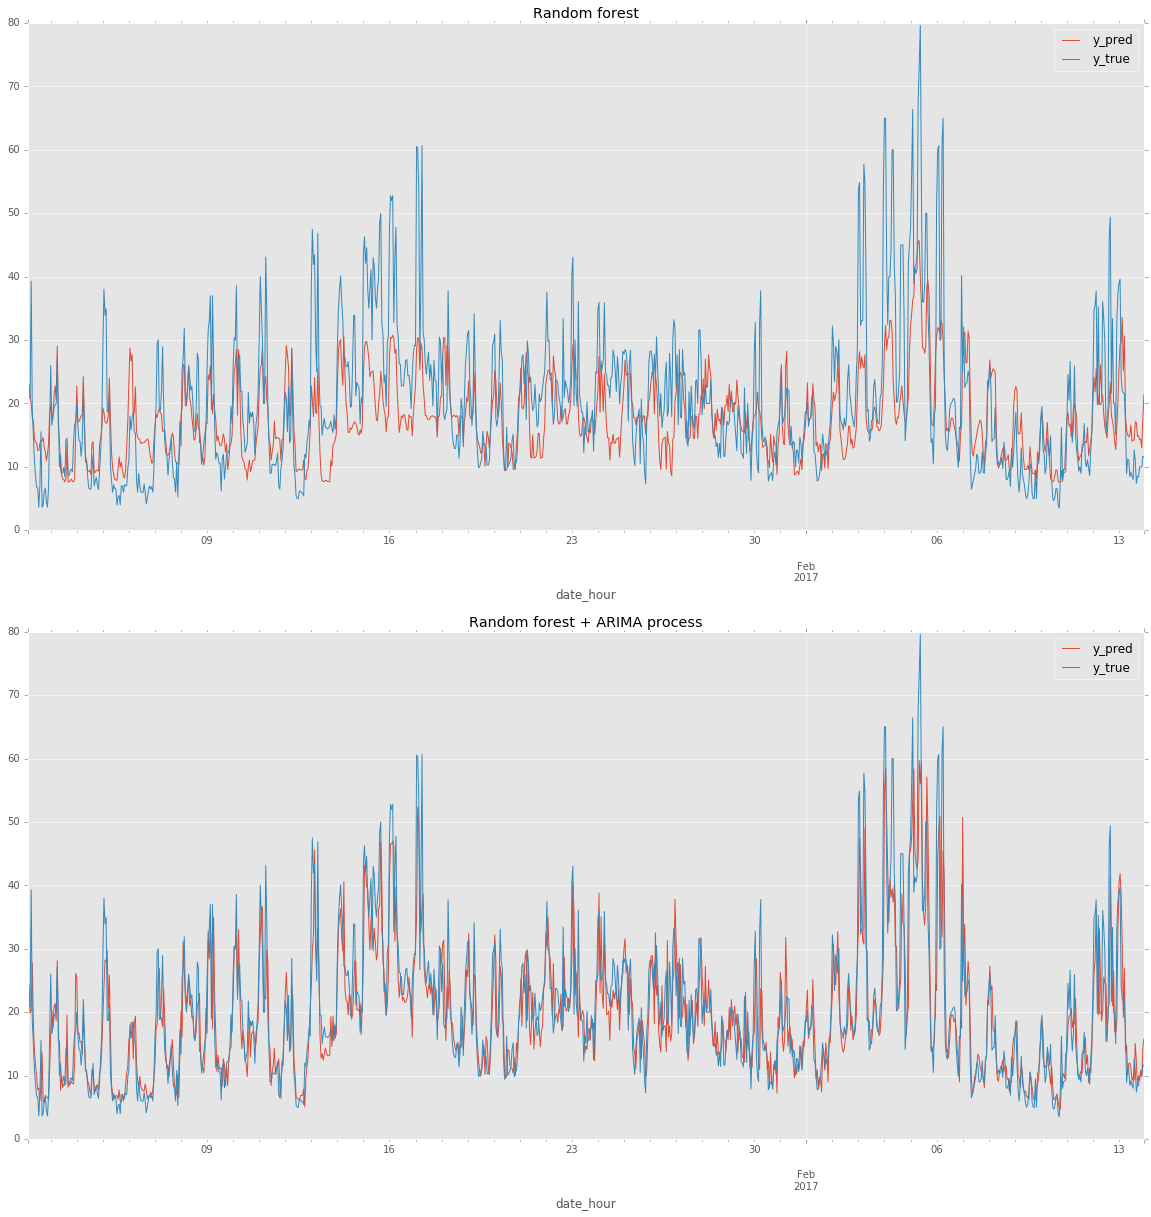

In [61]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(20,20))
residuals[['y_pred', 'y_true']].iloc[3:].plot(ax=ax0)
ax0.set_title('Random forest')
rf_ar_df.plot(ax=ax1)
ax1.set_title('Random forest + ARIMA process');

In [59]:
print('MAE: %.4f, MSE: %.4f' %(mean_absolute_error(rf_ar_df['y_true'], rf_ar_df['y_pred']), 
                               mean_squared_error(rf_ar_df['y_true'], rf_ar_df['y_pred'])))

MAE: 3.9348, MSE: 34.6644


In [62]:
#Adding white noise N(0, sigma_x), sigma_x = 0.23 from arima model, to be included!
noise = np.random.normal(loc=0, scale=0.23, size=(len(residual)-3))

In [66]:
rf_ar_noise_df = pd.DataFrame(data=f_x[3:]*np.exp(res_ts + noise), index=spot_band_demand.index[3:], columns=['y_pred'])

In [67]:
rf_ar_noise_df['y_true'] = Y[3:]

In [69]:
print('MAE: %.4f, MSE: %.4f' %(mean_absolute_error(rf_ar_noise_df['y_true'], rf_ar_noise_df['y_pred']), 
                               mean_squared_error(rf_ar_noise_df['y_true'], rf_ar_noise_df['y_pred'])))

MAE: 5.3801, MSE: 58.0032


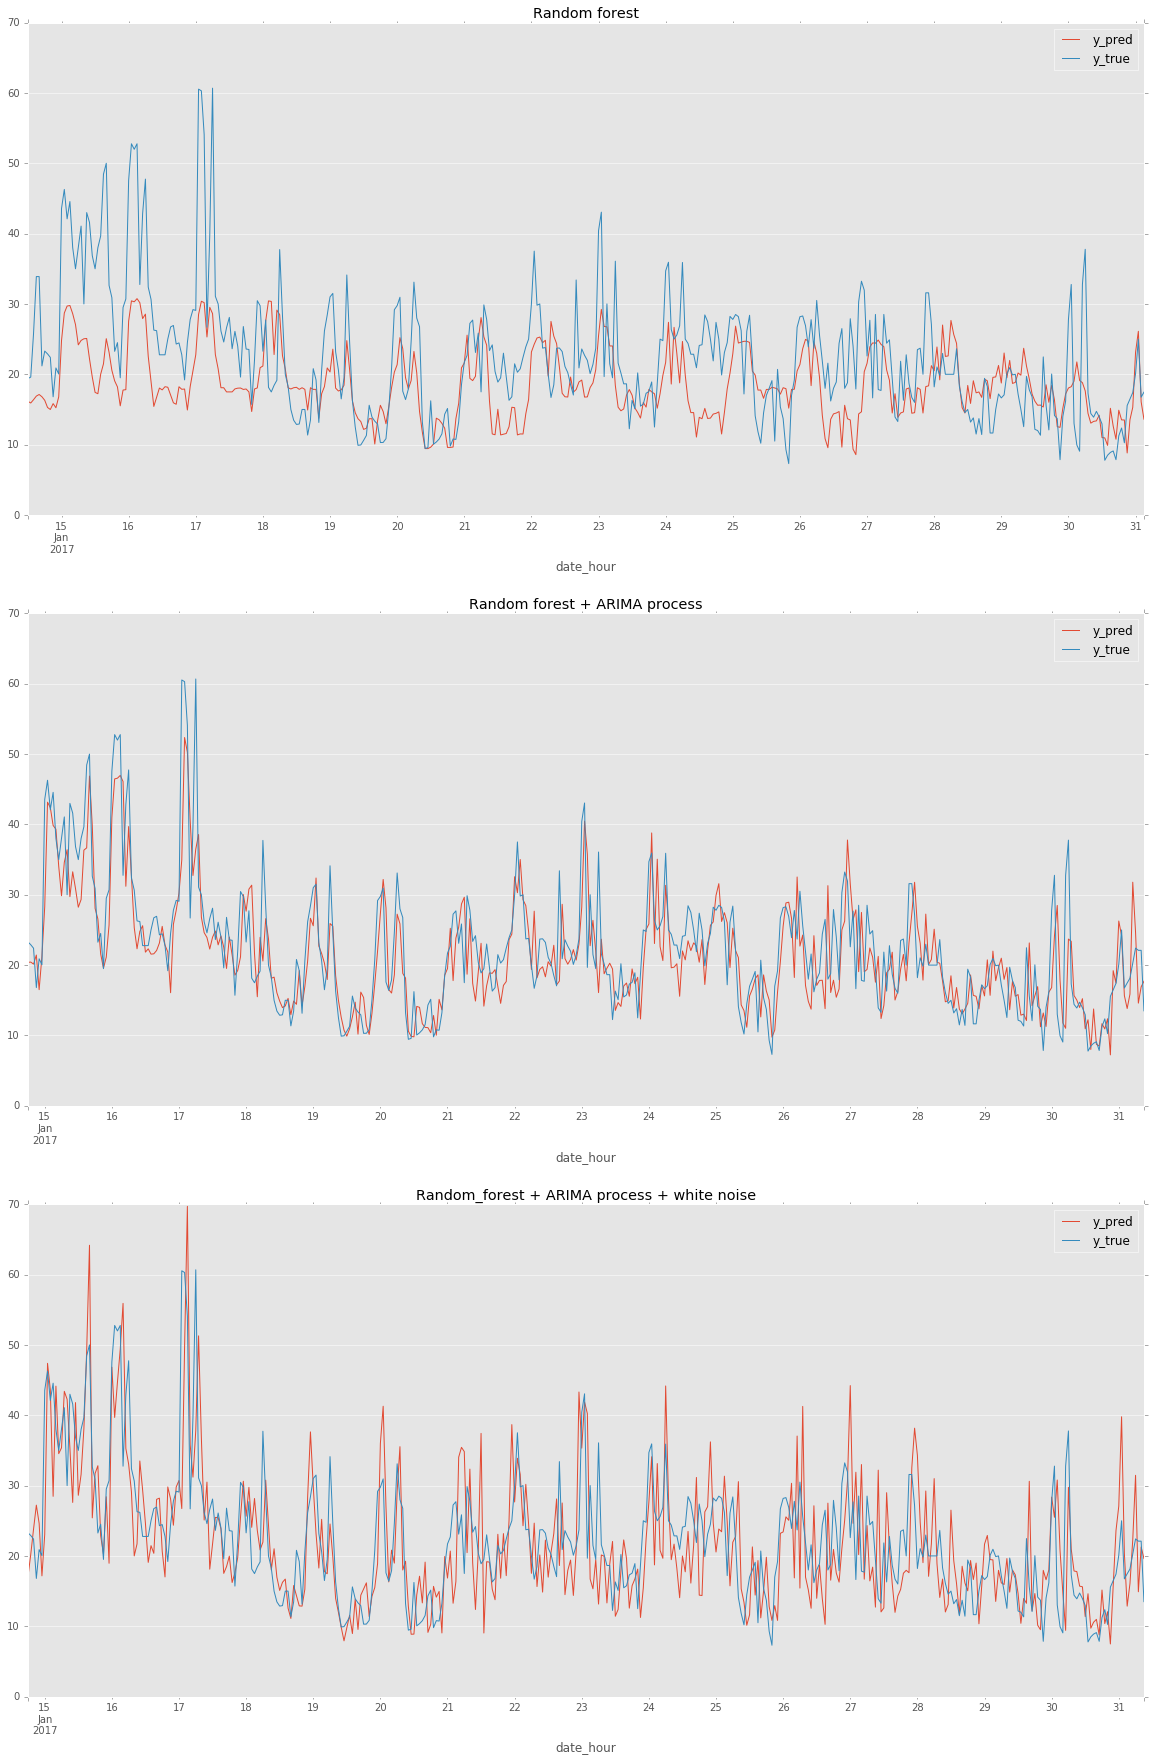

In [72]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1, figsize=(20,30))
residuals[['y_pred', 'y_true']].iloc[300:700].plot(ax=ax0)
ax0.set_title('Random forest')
rf_ar_df.iloc[303:703].plot(ax=ax1)
ax1.set_title('Random forest + ARIMA process')
rf_ar_noise_df.iloc[303:703].plot(ax=ax2)
ax2.set_title('Random_forest + ARIMA process + white noise');